# Targeted marketing with Customer segmention 


- Here, targeted marketing will be done by analysing customer behaviour.
- Hence, K-means clustering will be performed to segment customers
- In actual practice, marketing campaigns might be rolled out to 100K - 200K customers with different purchasing attributes.
- If you run multiple iterations of K Means on your local system. For K=4, the number of distance metrics required to be calculated is 4 x 100K = 400,000
- Hence, a lot of computation power is required. This is where data parallelism steps in

Data parrelism is achieved with the help of RDD's as shown in the below figure -:

<img src="https://www.researchgate.net/profile/Zhiang-Wu/publication/312487404/figure/fig1/AS:573268115169280@1513689177637/Framework-overview_Q320.jpg">

Imagine 100K records divided across 3 processors each having ~33K records. This is where distributed processing comes into the picture to reduce the volume of data, yet ensuring a complete result.

Note: Notebook executed on Kaggle Notebook (Cloud)

In [1]:
# References
# https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b
# https://www.researchgate.net/publication/312487404_Parallelizing_K-Means-Based_Clustering_on_Spark
# https://stackoverflow.com/questions/44888415/how-to-set-k-means-clustering-labels-from-highest-to-lowest-with-python/44912014
# # https://guillaume-martin.github.io/rfm-segmentation-with-python.html

# Libraries

In [2]:
import numpy as np
import pandas as pd 
import os

import seaborn as sns

import matplotlib.pyplot as plt

import plotly.express as px
plt.style.use('ggplot')
import plotly.io as pio
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

     |████████████████████████████████| 212.4 MB 58 kB/s s eta 0:00:01    |█████▊                          | 37.8 MB 19.4 MB/s eta 0:00:09     |██████████▎                     | 68.5 MB 40.0 MB/s eta 0:00:04     |█████████████████▏              | 113.7 MB 65.0 MB/s eta 0:00:02     |███████████████████▉            | 132.0 MB 65.0 MB/s eta 0:00:02
     |████████████████████████████████| 198 kB 54.2 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=dfb6c408111a49a3b976d4613ed0d801090fe58a7f82bd3903f38168709d6dcf
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


# Data preprocessing

In [3]:
# specify encoding to deal with different formats
df = pd.read_csv('../input/ecommerce-data/data.csv', encoding = 'ISO-8859-1')
df.head(10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [4]:
print(df.dtypes)

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


Some attributes of the data

```
InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
Description: Product (item) name. Nominal.
Quantity: The quantities of each product (item) per transaction. Numeric.
InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice: Unit price. Numeric, Product price per unit in sterling.
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
Country: Country name. Nominal, the name of the country where each customer resides.
```

In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


- As we can see some of the numerical fields are negative. This could be due to erronous values or refunds 
- This can be checked by comparing whether there are any duplicate invoice numbers or cancellations
- Letter c indicates cancellations in Invoice number. Lets check that. 

In [6]:
Cancellations = []

for i in range(len(df)):
    
    if "c" in df["InvoiceNo"].loc[i] or "C" in df["InvoiceNo"].loc[i] :
        
        Cancellations.append(1)
        
    else:
        pass

print("No of cancellations: ", len(Cancellations))

No of cancellations:  9288


In [7]:
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])

df.set_index(np.arange(0,len(df),1),inplace=True)
neg_df = df[df["Quantity"]<0]
pos_df = df[~df["Quantity"]<0]

print("No of total negative quantity: ",len(neg_df))

No of total negative quantity:  10624


In [8]:
neg_df.head(50)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom


Cancellations could amount to the negative quantity. Let's check for refunds. These can happen for
- Quantity lower than total bought quantity
- Bought after the purchase date
- Same customer id

In [9]:
check_for_truth = []

for j in neg_df.index:  
    
        for_ref = pos_df[(neg_df["CustomerID"].loc[j]==pos_df["CustomerID"]) & \
        (neg_df["Description"].loc[j]==pos_df["Description"])\
         &  (neg_df["InvoiceDate"].loc[j]>pos_df["InvoiceDate"]) & \
         (abs(neg_df["Quantity"].loc[j])<=pos_df["Quantity"])]
        
        if len(for_ref)>0:
            print("Refunds exists")
            break    
        
        


Refunds exists


### Let's check which items contribute to the most refunds

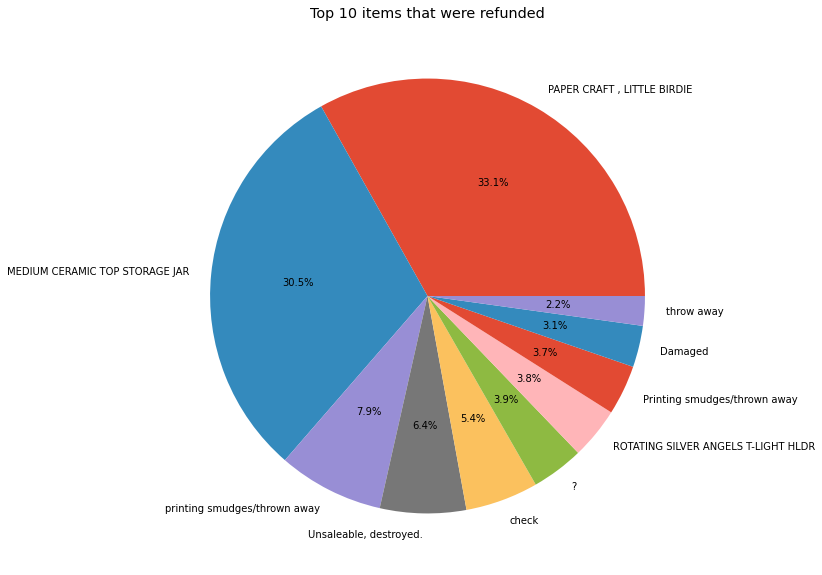

In [10]:
df_neg = neg_df[['Quantity','Description']].groupby("Description").sum()
df_neg["Quantity"] = abs(df_neg["Quantity"])

plt.figure(figsize=(10,10))
df_neg = df_neg.nlargest(10,columns="Quantity")
plt.title("Top 10 items that were refunded")
plt.pie(df_neg["Quantity"].to_list(),labels=df_neg.index,autopct='%1.1f%%')
plt.show()

- Paper craft little birdie along with medium ceramic top storage jar are the most refunded
- Refunded item details will not be deleted from the dataframe as they are vital later for correctly finding the revenue retention
- Additionally there are items mentioned as unsaleable, destroyed, printing smudges/thrown away which don't point to a specific item. These can be checked with stockcode

In [11]:
print(df[df.Description=="printing smudges/thrown away"])

print(df[df.Description=="Unsaleable, destroyed."])

print(df[df.Description=="check"])

       InvoiceNo StockCode                   Description  Quantity  \
225529    556690     23005  printing smudges/thrown away     -9600   
225530    556691     23005  printing smudges/thrown away     -9600   

               InvoiceDate  UnitPrice  CustomerID         Country  
225529 2011-06-14 10:37:00        0.0         NaN  United Kingdom  
225530 2011-06-14 10:37:00        0.0         NaN  United Kingdom  
       InvoiceNo StockCode             Description  Quantity  \
431375    573590    79323G  Unsaleable, destroyed.      -657   
431376    573591    79323B  Unsaleable, destroyed.     -1671   
431377    573592   79323GR  Unsaleable, destroyed.     -1158   
431378    573593   79323LP  Unsaleable, destroyed.     -2618   
431379    573594    79323P  Unsaleable, destroyed.     -2003   
431380    573595    79323S  Unsaleable, destroyed.      -674   
431381    573596    79323W  Unsaleable, destroyed.     -4830   
431382    573597     79341  Unsaleable, destroyed.      -905   
431383   

- Since, they lack a CustomerID, they could be refunds at the company level i.e. refunds during purchase from the supplier
- Let's check for negative price

In [12]:
neg_price = df[df["UnitPrice"]<0]
print(neg_price)

       InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom  


- Since this does not count as a customer, let's delete it 

In [13]:
df = df[df["UnitPrice"]>0]

- Remove possible duplicates and check for null values

In [14]:
df = df.drop_duplicates(keep='first')
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132565
Country             0
dtype: int64

- From above, some descriptions are NaN, but they don't appear here.
- Maybe they are text, let's find them and convert them to null values

In [15]:
df["Description"] = df["Description"].apply(lambda x:np.nan if x.lower() == "nan" else x)
print(df.isnull().sum()) # Seems to be zero for zero unit price

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132565
Country             0
dtype: int64


In [16]:
print(df[df["CustomerID"].isna()])

       InvoiceNo StockCode                      Description  Quantity  \
1443      536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444      536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445      536544     21786               POLKADOT RAIN HAT          4   
1446      536544     21787            RAIN PONCHO RETROSPOT         2   
1447      536544     21790               VINTAGE SNAP CARDS         9   
...          ...       ...                              ...       ...   
541536    581498    85099B          JUMBO BAG RED RETROSPOT         5   
541537    581498    85099C   JUMBO  BAG BAROQUE BLACK WHITE         4   
541538    581498     85150    LADIES & GENTLEMEN METAL SIGN         1   
541539    581498     85174                S/4 CACTI CANDLES         1   
541540    581498       DOT                   DOTCOM POSTAGE         1   

               InvoiceDate  UnitPrice  CustomerID         Country  
1443   2010-12-01 14:32:00       2.51         NaN  Unit

- This could probably be customers whose details have not been taken down
- To ensure our analysis are correct, drop rows with null values throughout
- Additionally some items are coded less than 5, they seem to some kind of delivery charge

In [17]:
# String nan
columns = ["InvoiceNo","StockCode","Country","Description"]
for column in columns:
    df[column] = df[column].apply(lambda x:np.nan if x.lower=="nan" else x)   
  
df.dropna(inplace=True)


Lets look at the stock code especially where there are instance of codes with length less than 5

In [18]:
df_sc = df[df.StockCode.str.len()<5]
print(df_sc["StockCode"].value_counts())

POST    1196
M        454
C2       134
D         77
DOT       16
CRUK      16
PADS       3
Name: StockCode, dtype: int64


In [19]:
print("POST",df_sc[df_sc.StockCode=="POST"]["Description"].head(1))
print("DOT",df_sc[df_sc.StockCode=="DOT"]["Description"].head(1)) 
print("M",df_sc[df_sc.StockCode=="M"]["Description"].head(1)) 
print("C2",df_sc[df_sc.StockCode=="C2"]["Description"].head(1))
print("D",df_sc[df_sc.StockCode=="D"]["Description"].head(1)) 
print("S",df_sc[df_sc.StockCode=="S"]["Description"].head(1))
print("CRUK",df_sc[df_sc.StockCode=="CRUK"]["Description"].head(1))
print("PADS",df_sc[df_sc.StockCode=="PADS"]["Description"].head(1))
print("B",df_sc[df_sc.StockCode=="B"]["Description"].head(1))
print("M",df_sc[df_sc.StockCode=="M"]["Description"].head(1))

POST 45    POSTAGE
Name: Description, dtype: object
DOT 317507    DOTCOM POSTAGE
Name: Description, dtype: object
M 2239    Manual
Name: Description, dtype: object
C2 1423    CARRIAGE
Name: Description, dtype: object
D 141    Discount
Name: Description, dtype: object
S Series([], Name: Description, dtype: object)
CRUK 317508    CRUK Commission
Name: Description, dtype: object
PADS 157195    PADS TO MATCH ALL CUSHIONS
Name: Description, dtype: object
B Series([], Name: Description, dtype: object)
M 2239    Manual
Name: Description, dtype: object


- These seem to be additional charges for delivery and additional services. It would be better to remove them as they might inflate the revenue figures (except for discount)
- Before that, let's check for stock code greater than 5

In [20]:
df_sc = df[(df.StockCode.str.len()>5)]
print(df_sc.head(2))
df_sc = df[(df.StockCode.str.len()>6)]
print(df_sc.head(2))
df_sc = df[(df.StockCode.str.len()>7)]
print(df_sc.head(2))

  InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
    InvoiceNo StockCode              Description  Quantity  \
132    536381   15056BL  EDWARDIAN PARASOL BLACK         2   
281    536396   15056BL  EDWARDIAN PARASOL BLACK         6   

            InvoiceDate  UnitPrice  CustomerID         Country  
132 2010-12-01 09:41:00       5.95     15311.0  United Kingdom  
281 2010-12-01 10:51:00       4.95     17850.0  United Kingdom  
      InvoiceNo     StockCode   Description  Quantity         InvoiceDate  \
4406     536779  BANK CHARGES  Bank Charges         1 2010-12-02 15:08:00   
62508    541505  BANK CHARGES  Bank Charges         1 2011-01

- Delete additional and bank charges as bank charges might be due to transaction charges and will inflate actual revenue to the company through customers

In [21]:
df = df[~((df.StockCode.str.len()<5) & (df.StockCode!="D"))]
df = df[df.StockCode.str.lower() !="bank charges"]

- Let's further check stock code. Is each product associated with a single stock code

<AxesSubplot:xlabel='StockCode'>

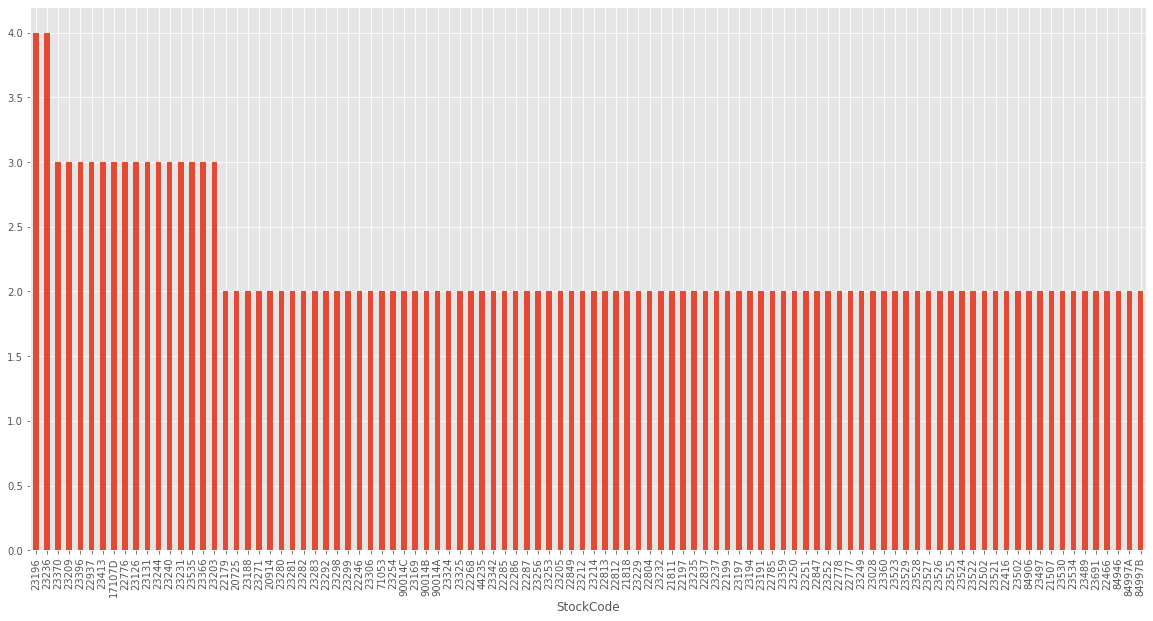

In [22]:
stock_code_df = df[["StockCode","Description"]].groupby("StockCode")["Description"].nunique()
stock_code_df = stock_code_df.sort_values(ascending=False)
plt.figure(figsize=(20,10))
stock_code_df.head(100).plot(kind='bar')

In [23]:
stockcode = df[["StockCode","Description"]].groupby("StockCode")["Description"].unique()
print("Product for stock code 23196: " + stockcode.at["23196"])

print("Product for stock code 23236: " + stockcode.at["23236"])

print("Product for stock code 21243: " + stockcode.at["21243"])

['Product for stock code 23196: RETRO LEAVES MAGNETIC NOTEPAD'
 'Product for stock code 23196: RETO LEAVES MAGNETIC SHOPPING LIST'
 'Product for stock code 23196: LEAVES MAGNETIC  SHOPPING LIST'
 'Product for stock code 23196: VINTAGE LEAF MAGNETIC NOTEPAD']
['Product for stock code 23236: DOILEY STORAGE TIN'
 'Product for stock code 23236: DOILEY BISCUIT TIN'
 'Product for stock code 23236: STORAGE TIN VINTAGE DOILY '
 'Product for stock code 23236: STORAGE TIN VINTAGE DOILEY ']
['Product for stock code 21243: PINK  POLKADOT PLATE '
 'Product for stock code 21243: PINK POLKADOT PLATE ']


- Stockcode seems to denote similar items from different suppliers or with different spellings
- So rather than analysing with product descriptions, it would be advisable with stock codes for some of the analysis

# Derivation of marketing strategies

## Customer segmentation will be achieved with an RFM matrix. It has three indicators 
```
1. Recency - When the customer last bought from the store. Calculated with the difference between the last date of purchase ever to date of purchase
2. Frequency - No of times customer has bought from the store
3. Monetary - Total purchase from the customer
```

- Here, let's analyse only based on purchases not based on returns or cancellations
- For Germany alone, for targeted marketing

In [24]:
df = df.loc[df.Country=="Germany",:]
df = df[~df['InvoiceNo'].str.contains('C', na=False)]
df = df[df["Quantity"]>0]
df["Individual Revenue"] = df["Quantity"]*df["UnitPrice"]

# Non consideration of discounts
df = df[df["StockCode"]!='D']

In [25]:
# Latest purchase
max_date = df["InvoiceDate"].max()

rfm_df = df.groupby("CustomerID").agg({"InvoiceDate":lambda date: (max_date - date.max()).days,
                                      "InvoiceNo": 'count',
                                      "Individual Revenue":'sum'})

rfm_df.rename(columns={"InvoiceDate":"Recency","InvoiceNo":"Frequency","Individual Revenue":"Monetary"},inplace=True)
print(rfm_df)

            Recency  Frequency  Monetary
CustomerID                              
12426.0         193         29    510.73
12427.0          21         28    699.80
12468.0         187         36    657.54
12471.0           1        438  17388.65
12472.0          31        332   6068.11
...             ...        ...       ...
13814.0          91         57   1579.12
13815.0          21        173   3667.36
13816.0          23         26    499.67
13817.0          28         22    328.98
14335.0          15         60    454.86

[94 rows x 3 columns]


In [26]:
#Create PySpark SparkSession
spark = SparkSession.builder.appName("Clustering using K-Means").getOrCreate()

#Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(rfm_df) 
sparkDF.printSchema()
sparkDF.show()

root
 |-- Recency: long (nullable = true)
 |-- Frequency: long (nullable = true)
 |-- Monetary: double (nullable = true)

+-------+---------+------------------+
|Recency|Frequency|          Monetary|
+-------+---------+------------------+
|    193|       29| 510.7299999999999|
|     21|       28| 699.8000000000002|
|    187|       36|            657.54|
|      1|      438|17388.649999999954|
|     31|      332| 6068.110000000003|
|     53|      160| 2585.729999999999|
|     16|      406|           6694.09|
|     53|       35|            669.38|
|     14|      224|5898.4200000000055|
|     22|      300| 13219.73999999999|
|     10|       30|             473.2|
|     27|      150|2885.6300000000006|
|     22|      208| 5003.820000000002|
|     62|       18|227.20999999999998|
|     80|       13|             953.1|
|     20|       21|             349.7|
|     22|       52|4059.8200000000006|
|    335|      148|2025.3899999999992|
|     17|        8|428.04999999999995|
|     77|       24| 

# Customer segmentation by behaviour

## Finding suitable number of clusters

In [27]:
# For recency
silhouette_score_recency=[]
evaluator = ClusteringEvaluator()

# To turn specific columns to features for clustering
vecAssembler = VectorAssembler(inputCols=["Recency"], outputCol="features")
new_df = vecAssembler.transform(sparkDF)

K = np.arange(2,21,1)

for k in K:
    
    Kmeans=KMeans(featuresCol='features', k=k)    
    model=Kmeans.fit(new_df)    
    output=model.transform(new_df)        
    score = evaluator.evaluate(output)    
    silhouette_score_recency.append(score)  
    
# For frequency   
silhouette_score_frequency=[]
evaluator = ClusteringEvaluator()

vecAssembler = VectorAssembler(inputCols=["Frequency"], outputCol="features")
new_df = vecAssembler.transform(sparkDF)

for k in K:
    
    Kmeans=KMeans(featuresCol='features', k=k)    
    model=Kmeans.fit(new_df)    
    output=model.transform(new_df)        
    score = evaluator.evaluate(output)    
    silhouette_score_frequency.append(score)  

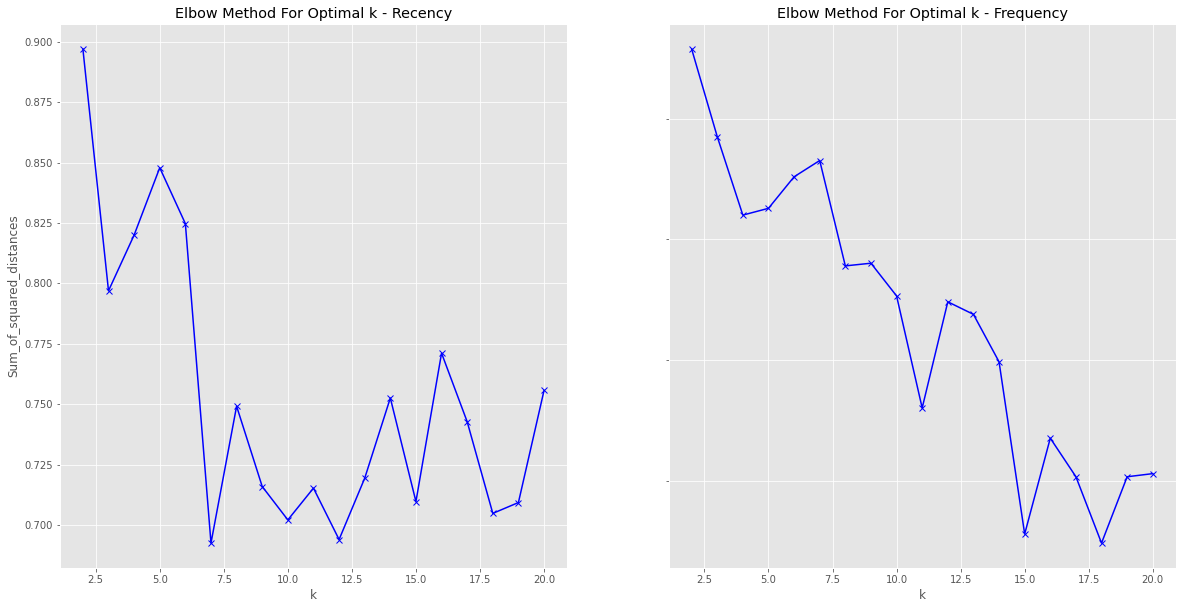

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].plot(K, silhouette_score_recency, 'bx-')
ax[0].set_title('Elbow Method For Optimal k - Recency')


ax[1].plot(K, silhouette_score_frequency, 'bx-')
ax[1].set_title('Elbow Method For Optimal k - Frequency')

for a in ax.flat:
    a.set(xlabel='k', ylabel='Sum_of_squared_distances')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()
    
plt.show()

## Clustering, ordering and attaching them to original database
- From above, 6 would be appropriate cluster for both recency and frequency
- Although 15 would be appropriate, that would mean too many labels for a directed marketing action

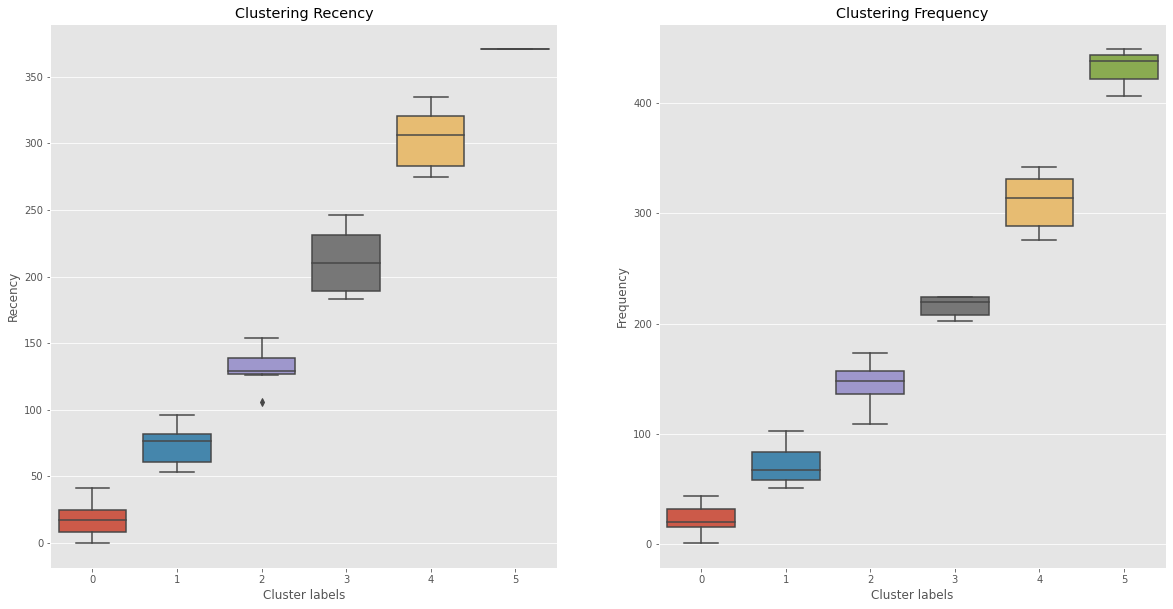

In [29]:
k=6

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
labels = ["Recency","Frequency"]

Cluster_labels = []

for i in range(len(labels)):
    
    vecAssembler = VectorAssembler(inputCols=[labels[i]], outputCol="features")
    new_df = vecAssembler.transform(sparkDF)
    
    Kmeans=KMeans(featuresCol='features', k=k)    
    model=Kmeans.fit(new_df)    
    output=model.transform(new_df)
    
   
    # Ordering clusters with numerical order
    predictions = output.select("prediction").rdd.flatMap(lambda x: x).collect()     
    idx = np.argsort(np.array(model.clusterCenters()).sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(k)
    

    dict = {
    labels[i]: rfm_df[labels[i]].tolist(),
    "Cluster_labels": list(lut[predictions])
     }
    param_df=pd.DataFrame.from_dict(dict,orient='index').transpose()
    sns.boxplot(x="Cluster_labels", y=labels[i], data=param_df,ax=ax[i])
    
    ax[i].set(xlabel="Cluster labels", ylabel = labels[i])
    ax[i].title.set_text("Clustering " + labels[i])
    
        
    rfm_df["Cluster labels - " + str(labels[i])] = list(lut[predictions])

    
    
plt.show()

# Creation of an appropriate marketing strategy

In [30]:
segt_map = {
    r'[0-2][0-2]': 'First timers - SMS ads',
    r'[0-2][3-4]': 'At risk - Discounts',
    r'[0-2]5': 'Immediate targeting - Promotions',
    r'3[0-2]': 'About to lose - Feedback form',
    r'[3-5][4-5]': 'Regular customers - Loyalty cards',
    r'40': 'Promising - Instant vouchers',
    r'50': 'New customers - 50 % discounts on certain items',
    r'[4-5][1-3]': 'Potential regular customers - Loyalty cards',
    r'4[4-5]': 'Best customers - Loyalty cards',
    r'33': 'Need attention - Discounts'
}  # For example if customers hasn't bought for a long time and has tried the shop only once, an SMS ad might     
   # rekindle interest


rfm_df["RF class"] = rfm_df['Cluster labels - Recency'].apply(str)+ rfm_df['Cluster labels - Frequency'].apply(str) 

# Marketing strategy based on recency and frequnecy of shopping alone
rfm_df['Marketing strategy'] = rfm_df['Cluster labels - Recency'].apply(str)+ rfm_df['Cluster labels - Frequency'].apply(str)
rfm_df['Marketing strategy'] = rfm_df['Marketing strategy'].replace(segt_map, regex=True)
rfm_df.head(5)

,Recency,Frequency,Monetary,Cluster labels - Recency,Cluster labels - Frequency,RF class,Marketing strategy
CustomerID,,,,,,,
12426.0,193,29,510.73,3,0,30,About to lose - Feedback form
12427.0,21,28,699.80,0,0,00,First timers - SMS ads
12468.0,187,36,657.54,3,0,30,About to lose - Feedback form
12471.0,1,438,17388.65,0,5,05,Immediate targeting - Promotions
12472.0,31,332,6068.11,0,4,04,At risk - Discounts


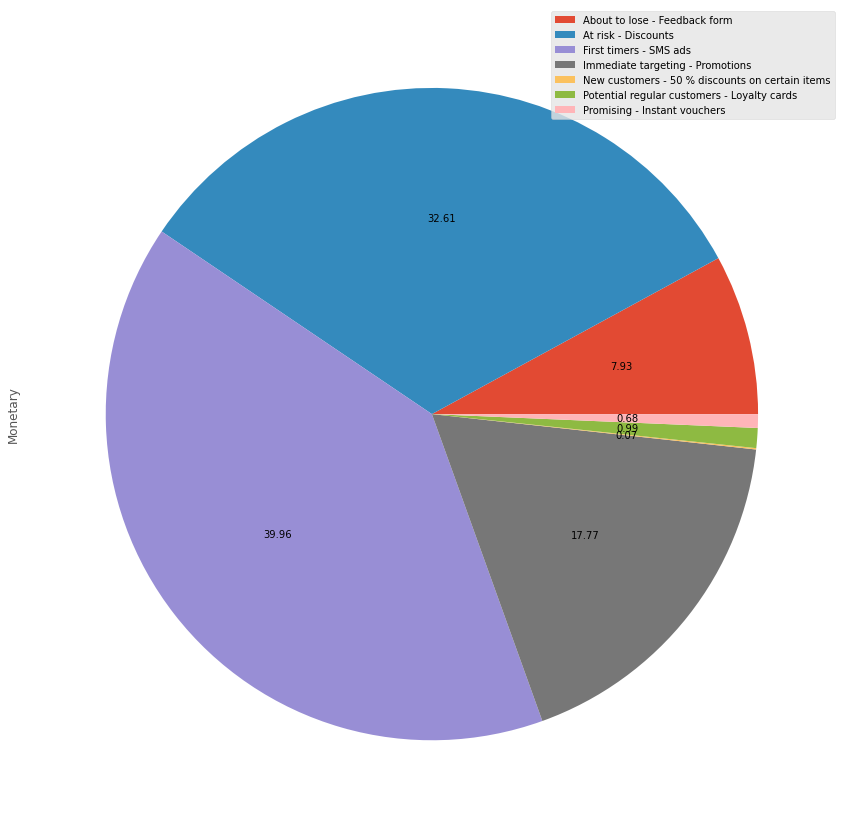

In [31]:
pie_plot_df = rfm_df[['Marketing strategy',"Monetary"]]
pie_plot_df = pie_plot_df.groupby('Marketing strategy').sum()
pie_plot_df.plot.pie(subplots=True, figsize=(15,15), autopct='%.2f', fontsize=10, labeldistance=None)
plt.show()

## Inferences
- Spending 39.96 % of the monetary value on SMS ads can contribute to increasing customer interest in the e-commerce shop
- Also, discounts and promotions are essential for increasing business value